____
# Анализ датасета `VIDEOGAMESALES`
<img src='data/dataset-cover.jpeg'></img>

Ресурс: https://www.kaggle.com/datasets/gregorut/videogamesales
___
### `Цель`: 
- найти наиболее перспективный жанр игры для потенциальной разработки.

### `Гипотеза`: 
- есть жанр игр (возможно в связке с платформой или что-то еще), который продается лучше.
___
## <a id='s'>СОДЕРЖАНИЕ</a>
- [Пропуски и дубликаты](#nan)
- [Типы данных](#typ)
- [Неинформативные признаки](#inf)
- [Выбросы и ошибки](#out)
- [Анализ данных](#an)
- [Корреляции между признаками](#corr)
- [Выводы](#sum)

___


___
## `Импорт` библиотек и датасета
Версии использованных библиотек:
- altair==5.1.2
- pandas==2.0.3
- numpy==1.25.2
- matplotlib==3.6.3
- matplotlib-inline==0.1.6
- seaborn==0.13.0
- python==3.11.1
___
## Исходные данные:

|  Столбец  |  Описание |
|:-------|:--------------------------:|
|  Rank  |  Рейтинг продаж |
|  Name  |  Название игры  |
|  Platform  |  Платформа релиза  |
|  Year  |  Год релиза  |
|  Genre  |  Жанр игры  |
|  Publisher  |  Компания, выпустившая игру  |
|  NA_Sales  |  Продажи в Северной Америке, млн $  |
|  EU_Sales  |  Продажи в Европе, млн $ |
|  JP_Sales  |  Продажи в Японии, млн $  |
|  Other_Sales  |  Продажи в других странах, млн $  |
|  Global_Sales  |  Мировые продажи, млн $  |
____


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

df = pd.read_csv('data/vgsales.csv.zip')
display(df[:2])
df.info()


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


___
## <a id='nan'>$$Пропуски \ и \ дубликаты$$</a> 
___

___
- ### `Функция` для нахождения столбцов с `NaN значениями`

In [130]:

def get_nan_columns(df:pd.DataFrame) ->list:

    columns = df.columns
    na_columns_lst = []
    for i in columns:
        if any(df[i].isnull()):
            na_columns_lst.append(i)
    return na_columns_lst


get_nan_columns(df)


['Year', 'Publisher']

___
- ### `Кол-во NaN` значений в столбцах

In [131]:
nan_columns = df.isna().sum().sort_values(ascending=False)
nan_columns = nan_columns[nan_columns > 0]
nan_columns


Year         271
Publisher     58
dtype: int64

___
- ### `Доля NaN` значений в столбцах
- доля NaN значений `незначительна`

In [132]:
nan_columns = df.isna().mean().sort_values(ascending=False)
nan_columns = nan_columns[nan_columns > 0]
nan_columns


Year         0.016327
Publisher    0.003494
dtype: float64

___
- ### `Тепловая карта` с пропусками
пропуски распределены в датасете `равномерно`

<AxesSubplot: >

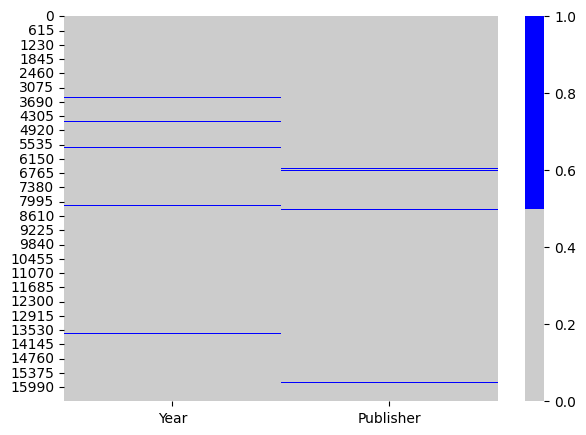

In [133]:
columns = nan_columns.index
plt.figure(figsize=(7,5))
sns.heatmap(df[columns].isna(), cmap=[(0.8,0.8,0.8),  'blue'] )


___
- ### `Заполнение` NaN значений
- доля NaN значений незначительна - строки можно удалить
- можно заполнить произвольным 'Unknown' значением

In [134]:
df['Publisher'].loc[ df['Publisher'].isna()] = 'Unknown Publisher'

C:\Users\nazar\AppData\Local\Temp\ipykernel_12420\3648852873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Publisher'].loc[ df['Publisher'].isna()] = 'Unknown Publisher'


___
- ### `Удаляем` строки с NaN значениями
т.к. их доля незначительна

In [135]:
old_size = df.shape[0]
df = df.dropna(how='any', axis=0)
print(f'Удалено {old_size - df.shape[0]} значений из {old_size}')


Удалено 271 значений из 16598


___
- ### Определяем `кол-во ` дубликатов
 - дублирующие строки `не обнаружены`

In [136]:
print(f'Кол-во дубликатов: {df.duplicated().sum()}')


Кол-во дубликатов: 0


___
## <a id='typ'>$$Типы \ данных $$</a> 
___

____
- ###  Преобразование столбца Year в тип `int` 

In [137]:
df['Year'] = df['Year'].astype('int64')


___
- ### `Преобразование` категориальных признаков в тип `category`
Тип category уменьшает использование памяти, кодирует категориальные значения целочисленными значениями

In [138]:
cat_columns = df.select_dtypes('object').astype('category')
df.drop(df.select_dtypes('object'), axis=1, inplace=True)
df = pd.concat((df, cat_columns),axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 16327 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Rank          16327 non-null  int64   
 1   Year          16327 non-null  int64   
 2   NA_Sales      16327 non-null  float64 
 3   EU_Sales      16327 non-null  float64 
 4   JP_Sales      16327 non-null  float64 
 5   Other_Sales   16327 non-null  float64 
 6   Global_Sales  16327 non-null  float64 
 7   Name          16327 non-null  category
 8   Platform      16327 non-null  category
 9   Genre         16327 non-null  category
 10  Publisher     16327 non-null  category
dtypes: category(4), float64(5), int64(2)
memory usage: 1.5 MB


___
## <a id='inf'>$$Неинформативные \ признаки$$</a>
Признаки, состоящие из значений повторяющихся на 95% или на 95% уникальные
___

___
- ### `Функция` для определения `неинформативных признаков`

In [139]:
def get_uninfo(df:pd.DataFrame, uninfo_dict:dict=None, border:int=0.95) -> dict:
    """Возвращает словарь с неинформативными признаками:
    с часто повторяющимися значениями или множеством уникальных

    Args:
        df (pd.DataFrame): Датасет
        uninfo_dict (dict, optional): Словарь для неинформативных признаков. Defaults to None.
        border (int, optional): Пороговая доля неинформативных значений в столбце. Defaults to 0.95.

    Returns:
        dict: Словарь с неинформативными признаками
    """
    if uninfo_dict is not None:
        uninfo_dict = {}
    else:
        uninfo_dict = {}
        for column in df.columns:
            high_freq= df[column].value_counts(normalize=True).max() # доля самого частого значения в столбце
            unique_ratio = df[column].nunique() / df.shape[0] # доля уникальных значений в столбце
            if high_freq > border:
                uninfo_dict[column] = f'Доля повторяющихся значений: {high_freq}'
            elif unique_ratio > border:
                uninfo_dict[column] = f'Доля уникальных значений: {high_freq}'
        return uninfo_dict


___
- ### Столбцы с `неинформативными` признаками
Rank - важный признак, определяющий востребованность игры на рынке 

In [140]:
get_uninfo(df)


{'Rank': 'Доля уникальных значений: 6.124823911312549e-05'}

___
## <a id='out'>$$Выбросы \ и \ ошибки$$</a>
___

___
- ### `Описательные статистики`
Значения продаж:
- Отрицательных значений в продажах нет
- Средние мировые продажи = сумме всех  продаж во всех локациях
- Средние, максимальные, минимальные значения соответсвуют размерам рынков видеоигр

Значения рейтинга:
- Отрицательных значений в продажах нет

Вывод: **`аномалии не обнаружены`**

In [141]:
df.describe()


,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000,16327.000000
mean,8292.868194,2006.406443,0.265415,0.147554,0.078661,0.048325,0.540232
std,4792.669778,5.828981,0.821591,0.508766,0.311557,0.189885,1.565732
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4136.500000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8295.000000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12441.500000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.480000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


___
- ### `Относительная разница` сумм продаж Global и все слагаемые локации
    - Разница незначительная : `аномалии не обнаружены`

In [142]:
global_sales = df['Global_Sales'].sum()
total_sales = df['EU_Sales'].sum() + df['NA_Sales'].sum() + df['JP_Sales'].sum() + df['Other_Sales'].sum()
relative_difference = (global_sales - total_sales) / global_sales
print(f'Относительная несходимость сумм продаж: {relative_difference}')


Относительная несходимость сумм продаж: 0.0005101832578262111


____
- ### `Распределение продаж`
    - Продажи имеют логарифмическое распределение, т.к. ограничены 0=нулевым значением
    - Характер распределения следует учитывать при анализе выбросов

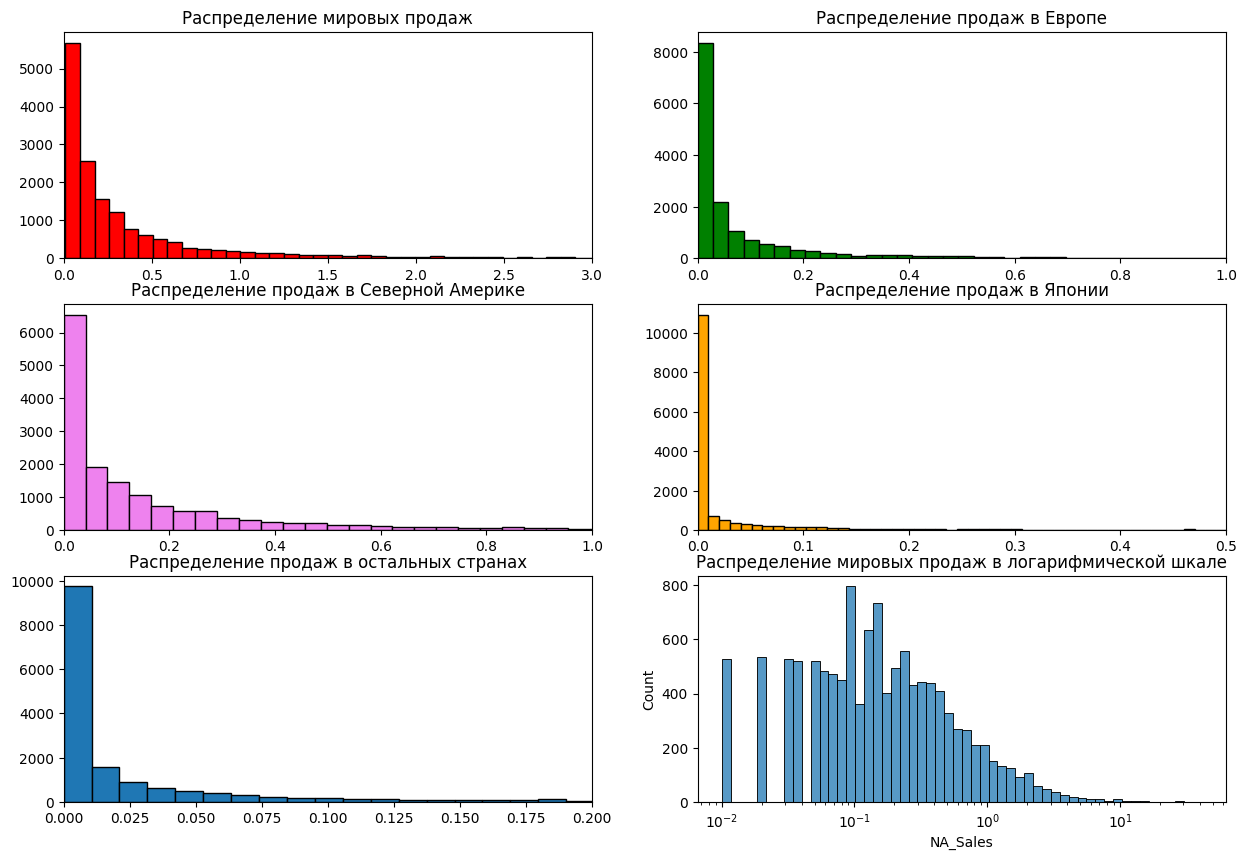

In [143]:
fig, ax = plt.subplots(3,2, figsize=(15,10))
ax[0,0].hist(df['Global_Sales'], bins=1000, edgecolor='black', color='red')
ax[0,0].set_xlim(0,3)
ax[0,0].set_title('Распределение мировых продаж')


ax[0,1].hist(df['EU_Sales'], bins=1000, edgecolor='black',color='green')
ax[0,1].set_xlim(0,1)
ax[0,1].set_title('Распределение продаж в Европе')


ax[1,0].hist(df['NA_Sales'], bins=1000, edgecolor='black', color='violet')
ax[1,0].set_xlim(0,1)
ax[1,0].set_title('Распределение продаж в Северной Америке')


ax[1,1].hist(df['JP_Sales'], bins=1000, edgecolor='black', color='orange')
ax[1,1].set_xlim(0,0.5)
ax[1,1].set_title('Распределение продаж в Японии')

ax[2,0].hist(df['Other_Sales'], bins=1000, edgecolor='black');
ax[2,0].set_xlim(0,0.2)
ax[2,0].set_title('Распределение продаж в остальных странах')


sns.histplot(df, x='NA_Sales', log_scale=True)

ax[2,1].set_title('Распределение мировых продаж в логарифмической шкале');


___
- ### Отображаем `коробчатые гистограммы` для анализа выбросов в продажах по жанрам
    - Наибольшие единичные продажи (выбросы) в жанре `Sports`  
    Так же выделяются жанры `Platform`, `Racing`
    - Выбросы имеются во всех жанрах, что говорит о наличии в `каждом жанре` отдельных игр с очень высокими продажами
    - Необходимо удалить выбросы, т.к. они искажают анализ

<AxesSubplot: xlabel='Global_Sales', ylabel='Genre'>

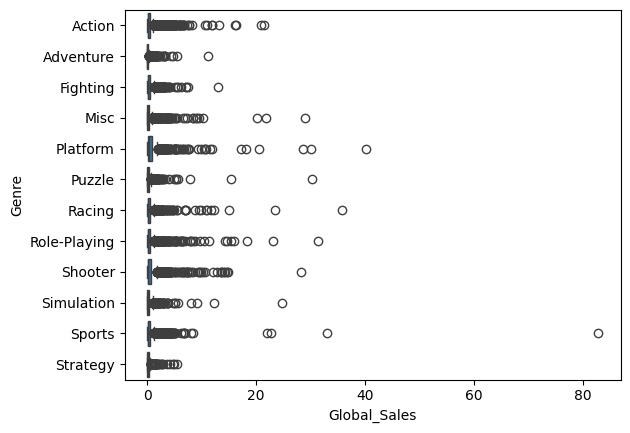

In [144]:
sns.boxplot(data=df, x=df['Global_Sales'], y=df['Genre'])


___
### `Функция` для удаления выбросов по методу Тьюки

$Граница_{нижняя} = Q_{25} - IQR \cdot  1.5$  
$Граница_{верхняя} = Q_{75} + IQR \cdot  1.5$  
$IQR = Q_{75} - Q_{25}$

In [145]:
def outliers_iqr(data: pd.DataFrame, feature : str, left:float=1.5, right:float=1.5, log_scale:bool=False) -> tuple:
    """Очищает датафрейм от выбросов по методу Тьюки

    Args:
        data (pd.DataFrame): датафрейм
        feature (str): столбец
        left (float, optional): число влево от IQR. Defaults to 1.5.
        right (float, optional): число вправо от IQR. Defaults to 1.5.

    Returns:
        tuple: датафрейм с выбросами,
        очищенный датафрейм от выбросов
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    quant_25, quant_75 = x.quantile(0.25), x.quantile(0.75)
    IQR = quant_75 - quant_25
    bond_low = quant_25 - IQR * left
    bond_up = quant_75 + IQR * right
    outliers = data[ (x < bond_low )| (x > bond_up )]
    cleaned_data = data[(x >= bond_low) & (x <= bond_up)]
    return outliers, cleaned_data


- ### `Удаляем выбросы` в продажах
    - Доля выбросов незначительна
    - Наименьший процент выбросов в мировых продажах - наиболее подходящий признак для анализа

In [146]:
df_cleaned = df.copy()
sales_columns = df.drop(['Year', 'Name', 'Platform', 'Publisher', 'Genre', 'Rank'], axis=1).columns
for column in sales_columns:
    outliers,df_cleaned = outliers_iqr(df_cleaned, column, log_scale=True, right=1.5)
    print(f'Из столбца {column} удалено {outliers.shape[0]/df[column].shape[0] * 100:.1f} процента данных')


Из столбца NA_Sales удалено 8.4 процента данных
Из столбца EU_Sales удалено 9.0 процента данных
Из столбца JP_Sales удалено 13.6 процента данных
Из столбца Other_Sales удалено 3.1 процента данных
Из столбца Global_Sales удалено 2.3 процента данных


____
- ### Коробчатые гистограммы `после удаления выбросов`

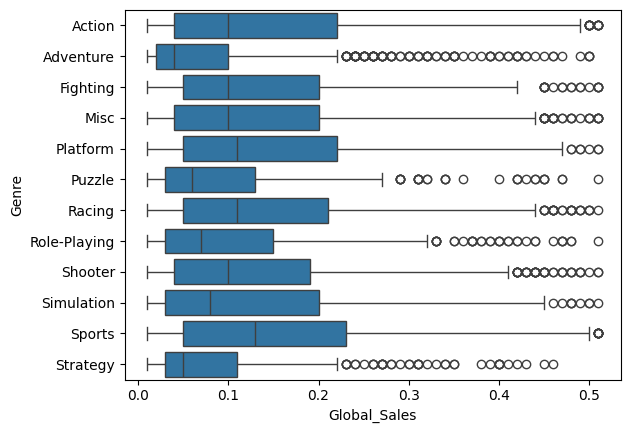

In [147]:
sns.boxplot(data=df_cleaned, x=df_cleaned['Global_Sales'], y=df_cleaned['Genre']);


___
## <a id='an'>$$Анализ \ данных$$</a>
___

___
## $$Жанры$$

___
- ### `Доля` данных для жанров
Доля может представлять предпочтения целевой аудитории.

- Наименьшая доля представленных данных для жанров `Platform`, `Strategy`, `Fighting`, `Adventure` и `Puzzle`.  
Если есть возможность, было бы полезно собрать дополнительные данные по этим жанрам.
- Наибольшая доля данных для жанров `Action`, `Sports`, `Misc`, `Adventure`.


In [148]:
genre_pie = df_cleaned['Genre'].value_counts(normalize=True)
genre_pie

Genre
Action          0.201080
Sports          0.131965
Misc            0.112686
Adventure       0.100540
Racing          0.080393
Shooter         0.073067
Role-Playing    0.070079
Simulation      0.054656
Platform        0.049258
Strategy        0.043570
Fighting        0.042510
Puzzle          0.040197
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Доля данных для жанров')

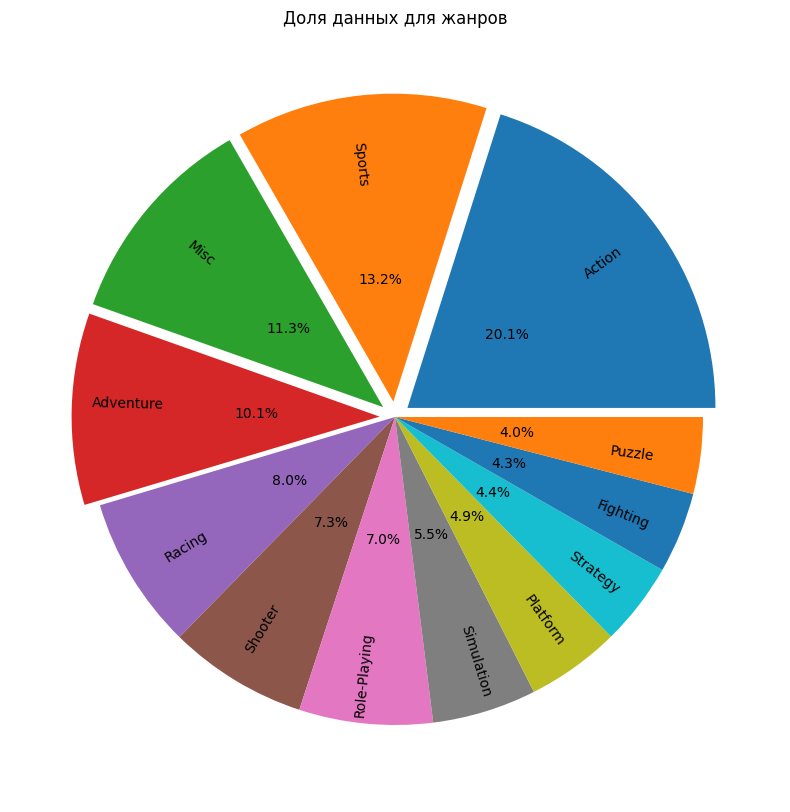

In [163]:
fig = plt.figure(figsize=(10,10))
plt.pie(genre_pie, labels=genre_pie.index, labeldistance=0.7, rotatelabels=1,autopct='%.1f%%',startangle=0,explode=[0.05,0.05,0.05,0.05,0,0,0,0,0,0,0,0],pctdistance=0.4);
plt.title('Доля данных для жанров')

____
- ### Характер распределения продаж по жанрам `за все время`
Для Мирового рынка:  
- Самые большая медиана продаж и максимальное значение продаж  у жанра `Sports`    
- Так же большие медианы продаж у жанров: `Action`, `Platform` и `Racing`

Для этих жанров большая доля игр имеет нивысшие значения Мировых продаж


Text(0.5, 1.0, 'Мировые продажи по жанрам за все время')

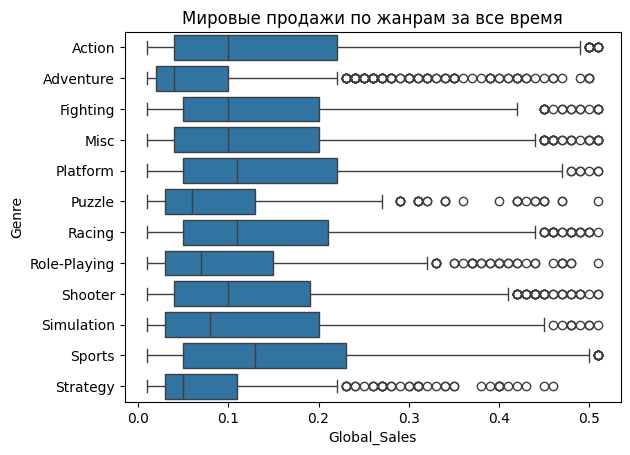

In [150]:
sns.boxplot(data=df_cleaned, x=df_cleaned['Global_Sales'], y=df['Genre'])
plt.title('Мировые продажи по жанрам за все время')


___
### `Последние тренды в индустрии`
Т.к. тренды в игровой индустрии стремительно меняются, для анализа рынка необходимо использовать данные последних лет
### Кол-во данных за каждый год
- Данных за 2020, 2017 год слишком мало, не следует их учитывать в анализе трендов

In [151]:
df_cleaned.groupby('Year')['Global_Sales'].count().reset_index().sort_values(by=['Year', 'Global_Sales'], ascending=False)[:12]


,Year,Global_Sales
37,2020,1
36,2017,3
35,2016,266
34,2015,421
33,2014,343
32,2013,292
31,2012,377
30,2011,781
29,2010,871
28,2009,1009


____
### Выбираем данные за `последние 12 лет` (за исключением 2017 и 2020)

In [152]:
latest_years = df_cleaned['Year'].value_counts().reset_index().sort_values(by='Year', ascending=False)['Year'][2:12].to_list()
year_df = df_cleaned[ df['Year'].isin(latest_years)]
year_bar = year_df[['Year', 'Global_Sales', 'Genre', 'Platform']].sort_values(by='Global_Sales')


C:\Users\nazar\AppData\Local\Temp\ipykernel_12420\3231012028.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  year_df = df_cleaned[ df['Year'].isin(latest_years)]


____
### Столбчатая диаграмма по мировым продажам `c 2007 по 2016 года` для каждого жанра 
- Заметна тенденция:
    - увеличения продаж для жанра  `Shooter`
    - уменьшения продаж для жанра `Platform`, `Racing`, `Puzzle`



In [153]:
alt.themes.enable('powerbi')
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [154]:
selection_legend = alt.selection_point(fields=['Genre'], bind='legend')
alt.Axis(tickSize=5)
bar_chart = alt.Chart(year_bar, width=1500, height=400)
bar_chart.mark_bar()\
    .encode(x=alt.X('Year:O', axis=alt.Axis(labelFontSize=20, labelColor='lightblue', titleFontSize=25, titleColor='lightblue')), y=alt.Y('mean(Global_Sales)',axis=alt.Axis(labelFontSize=20, labelColor='lightblue', titleFontSize=25, titleColor='lightblue')),xOffset='Genre', color='Genre',opacity=alt.condition(selection_legend, alt.value(1), alt.value((0.05))))\
        .add_params(selection_legend)\
            .interactive()\
            .configure_legend(labelFontSize=20, titleFontSize=25, symbolSize=300, symbolStrokeWidth=10, labelFont='isocper', labelColor='lightblue')\
                .properties(title='Средние мировые продажи для жанров').configure_title(fontSize=25, color='lightblue')


alt.Chart(...)

___
### `Средние` продажи для каждого `жанра` за период 2007 - 2016 года
- Наибольшие средние Мировые продажи у жанров:
    - `Sports`
    - `Platform`
    - `Shooter`


In [155]:
year_df.groupby(['Genre'])['Global_Sales'].mean().reset_index().sort_values(by='Global_Sales', ascending=False)

,Genre,Global_Sales
10,Sports,0.145725
4,Platform,0.144128
8,Shooter,0.140280
0,Action,0.134384
3,Misc,0.131700
6,Racing,0.129320
9,Simulation,0.128433
2,Fighting,0.126338
7,Role-Playing,0.099654
5,Puzzle,0.097831


___
### `Общие` продажи для каждого `жанра` за период 2007 - 2016 года
- Игры с жанром `Action` самые продаваемые, т.к. представлены на рынке в большей доле
- Ближайшие к лидирующему жанру `Misc`, `Sports`, `Adventure`

In [156]:
year_df.groupby(['Genre'])['Global_Sales'].sum().reset_index().sort_values(by='Global_Sales', ascending=False)


,Genre,Global_Sales
0,Action,179.94
3,Misc,104.57
10,Sports,98.51
1,Adventure,54.41
9,Simulation,51.63
8,Shooter,50.08
7,Role-Playing,46.14
6,Racing,43.71
2,Fighting,26.91
5,Puzzle,26.61


___
## $$Платформы + Жанры$$

___
### Общие Мировые продажи для `платформ` за период 2007 - 2016 года
- Наибольшие Мировые продажи у платформ:
    - `DS`
    - `Wii`
    - `X360`

In [157]:
platform_df =  year_df.groupby('Platform')['Global_Sales'].sum().reset_index().sort_values(by='Global_Sales', ascending=False)
platform_df[:5]

,Platform,Global_Sales
4,DS,158.24
26,Wii,144.62
28,X360,128.01
17,PS3,77.14
13,PC,39.96


____
### Столбчатая диаграмма по мировым продажам `c 2007 по 2016 года` для каждой платформы
- Заметна тенденция:
    - увеличения продаж для платформы  `WiiU`
    - к 2016 году рынок покинули ряд платформы, одни из них: `XB`, `Wii`, `PSP`, `PS2`, `GC`, `GBA`, `DS`, `DC`. Эти платформы не стоит рассматривать для разработки игр

In [158]:
selection_legend = alt.selection_point(fields=['Platform'], bind='legend')
alt.Axis(tickSize=5)
bar_chart = alt.Chart(year_bar, width=1500, height=400)
bar_chart.mark_bar()\
    .encode(x=alt.X('Year:O', axis=alt.Axis(labelFontSize=20, labelColor='lightblue', titleFontSize=25, titleColor='lightblue')), y=alt.Y('mean(Global_Sales)',axis=alt.Axis(labelFontSize=20, labelColor='lightblue', titleFontSize=25, titleColor='lightblue')),xOffset='Platform', color='Platform',opacity=alt.condition(selection_legend, alt.value(1), alt.value((0.05))))\
        .add_params(selection_legend)\
            .interactive()\
            .configure_legend(labelFontSize=20, titleFontSize=25, symbolSize=300, symbolStrokeWidth=10, labelFont='isocper', labelColor='lightblue')\
                .properties(title='Средние мировые продажи для платформ').configure_title(fontSize=25, color='lightblue')

alt.Chart(...)

___
### `Средние` продажи для каждого `жанра` и `платформы` за период 2007 - 2016 года
- Платформа `WiiU` с жанром `Racing` имеет наибольшие средние Мировые продажи
- Платформа `WiiU` представлена в списке 10 самых больших средних Мировых продажах в 3 жанрах:
    - `Racing`, `Sports`, `Simulation`
- Платформа `XOne` с жанром `Misc` имеет вторые средние Мировые продажи
- Платформа `XOne` представлена в списке 10 самых больших средних Мировых продажах в 2 жанрах:
    - `Misc`, `Platform`
- Платформа `X360` представлена в списке 10 самых больших средних Мировых продажах в 3 жанрах:
    - `Fighting`, `Strategy`, `Role-Playing`

Платформы: `WiiU`, `XOne`, `X360` - наиболее значимые для Мировых продаж

In [159]:
out_platforms = {'XB', 'Wii', 'PSP', 'PS2', 'GC', 'GBA', 'DS', 'DC'}
df = year_df.groupby(['Platform', 'Genre'])['Global_Sales'].mean().reset_index().sort_values(by='Global_Sales', ascending=False)
relevant_platform = list(year_df[ year_df['Year'] == 2016]['Platform'].unique())
df = df[ df['Platform'].isin(relevant_platform)]
df[:10]

,Platform,Genre,Global_Sales
330,WiiU,Racing,0.280000
363,XOne,Misc,0.264167
334,WiiU,Sports,0.236000
209,PS3,Puzzle,0.230000
338,X360,Fighting,0.216579
30,3DS,Racing,0.212500
333,WiiU,Simulation,0.210000
347,X360,Strategy,0.206316
364,XOne,Platform,0.202500
343,X360,Role-Playing,0.201944


____
### Столбчатая диаграмма по Мировым продажам `c 2007 по 2016 года` для каждого `жанра` и `платформы`
Жанры с наибольшими средними мировыми продажами:

- для платформы `WiiU` :
    - `Racing`, `Sports`, `Simulation`
- для платформы `XOne` :
    - `Misc`, `Platform`, `Simulation`
- для платформы `X360` :
    - `Fighting`, `Strategy`,  `Role-Playing`

Для каждой платформы есть жанры на которых они специализируются.


In [160]:
selection_legend = alt.selection_point(fields=['Genre'], bind='legend')
alt.Axis(tickSize=5)
bar_chart = alt.Chart(df, width=1500, height=400)
bar_chart.mark_bar()\
    .encode(x=alt.X('Platform:O', axis=alt.Axis(labelFontSize=20, labelColor='lightblue', titleFontSize=25, titleColor='lightblue')), y=alt.Y('mean(Global_Sales)',axis=alt.Axis(labelFontSize=20, labelColor='lightblue', titleFontSize=25, titleColor='lightblue')),xOffset='Genre', color='Genre',opacity=alt.condition(selection_legend, alt.value(1), alt.value((0.05))))\
        .add_params(selection_legend)\
            .interactive()\
            .configure_legend(labelFontSize=20, titleFontSize=25, symbolSize=300, symbolStrokeWidth=10, labelFont='isocper', labelColor='lightblue')\
                .properties(title='Средние мировые продажи игр для платформ и жанров').configure_title(fontSize=25, color='lightblue')

alt.Chart(...)

___
## <a id='corr'>$$Корреляции \ между \ признаками$$</a>
___

___
- ### `Матрица корреляций`
- Продажи во всех локациях имеют значимую корреляцию между собой (кроме Японии), что говорит об однородности предпочтений по всему миру.  
Наиболее отличаются предпочтения в Японии - при целевом ориентировании на японский рынок необходимо анализировать данные отдельно от Мировго рынка
- Продажи в Северной Америке и остальными странами сильно коррелируют с Мировыми продажами, эти рынки формируют Мировой рынок продаж видеоигр
- Рейтнг имеет очень значимую обратную корреляцию с мировыми продажами, т.к. основывается на мировых продажах

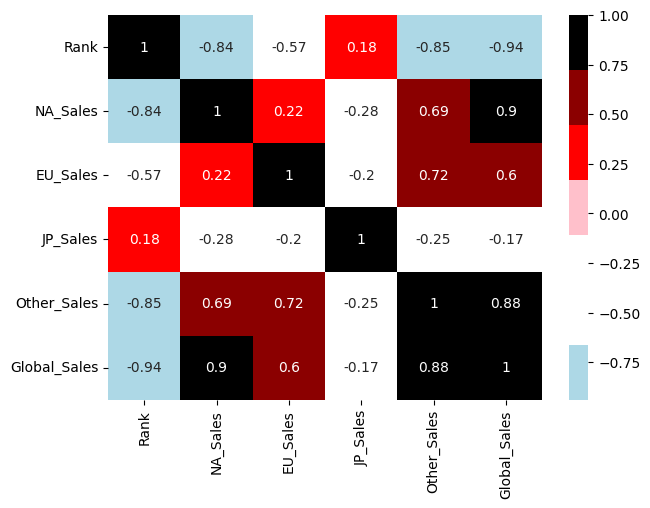

In [161]:
df_corr = year_df.drop(['Year', 'Name', 'Platform', 'Publisher', 'Genre'], axis=1)
corr = df_corr.corr('pearson')
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap=[ 'lightblue','white','white','pink', 'red', 'darkred', 'black']);


___
## <a id='sum'>$$Выводы$$</a>
___
___
$$РЫНКИ$$
- Для оценки перспективности жанра и платформы были использованы данные о Мировых продажах, т.к. рейтинг сильно скоррелирован с Мировыми продажами и доля пропущенных значений незначительна.

- Продажи в Северной Америке имеют большое влияние на Мировые продажи.
- В Японии сформировани свой рынок, отличающийся от всего мира. Для `Японии` выводы по жанрам и платформам `будут отличаться`.
$$ТЕНДЕНЦИИ$$
- Игровая индустрия - быстро изменяющаяся область, соответственно, для поиска наиболее перспективного жанра игры необходимо использовать наиболее свежие данные. Наиболее свежие данные предоставлены в период `с 2007 по 2016` года.

- Заметна тенденция увеличения продаж для жанра  `Shooter` и уменьшения продаж для жанров: `Platform`, `Racing`, `Puzzle`, что делает жанр `Shooter` наиболее привлекательным для разработки `без учета платформы`.
- К 2016 году многие платформы ушли с рынка, а платформы: `WiiU`, `XOne`, `X360` - наиболее значимые для Мировых продаж, что делает предпочтительной разработку для этих платформ.
$$ЖАНРЫ \ И \ ПЛАТФОРМЫ$$

- Для каждой платформы есть жанры на которых они специализируются - Мировые продажи максимальны.

- Платформа `WiiU` с жанром `Racing` имеет наибольшие средние Мировые продажи, платформа `XOne` с жанром `Misc` имеет вторые средние Мировые продажи, что делает эти жанры в связке с платформой наиболее перспективными для разработки.
- Для жанра `Shooter` платформа  с наибольшимим средними продажами - `X360`.

#### $$Наилучшие \ жанры \ и \ платформы \ для \ разработки$$

|  Жанр  |  `Платформа` | _Описание_ |
|:-------|:--------------------------:|:---------------:|
| **Shooter** | _не учитывая платформу_ | _наибольший тренд роста средних продаж_  |
| **Shooter** | X360 | _наибольший тренд роста средних продаж и платформа, специализирующаяся на этом жанре_  |
| **Racing** |  WiiU | _наибольшие средние продажи_  |
| **Misc** | XOne | _вторые по значимости средние продажи_  |




___
___
## $\uparrow$ [СОДЕРЖАНИЕ](#s)
___